#  <center>097400 - Technion - Introduction to Causal Inference</center>

##  <center>Homework 4</center> 

### <center>Winter 2020/2021</center>

### <center>Submission date: January 18 , 2021</center>


### <img src="https://img.icons8.com/bubbles/50/000000/information.png" style="height:50px;display:inline"> Students Information

|Name     |Campus Email| ID  |
|---------|--------------------------------|----------|
|Asaf Gendler| asafgendler@campus.technion.ac.il| 301727715|
|Shalev Shaer| shalev.shaer@campus.technion.ac.il| 305252520|


## Overview
In this homework assignment you will experience working with actual (partially simulated) data,
as preparation for the final project. You are more than encouraged to work in pairs. We generated
the data in a manner that guarantees there are no unmeasured confounders.

## The Data

Together with this document are two data files (\data1.csv" and \data2.csv"). Each contains
$n = 4802$ samples, with the following properties:
1. $ X_1 , X_2, ... , X_{58} $ : Covariates of the model (same in both datasets).
2. $T$ : The treatment assignment of the model (binary).
3. $Y$ : The outcome of the model.

## Requirements
Your task is to estimate the Average Treatment effect on the Treated (ATT), in both of the
datasets. For each dataset you should first calculate the propensity score, and then estimate the
ATT using the following approaches:
1. Inverse Propensity Score Weighting
2. S-learner
3. T-learner
4. Matching

The grade of this assignment will have two parts: 85% of the grade will be based on your ability
to calculate estimates for each of the models (i)-(iv) above. Then, for the remaining 15% of the
grade, we ask you to give your best estimate of the true ATT, using any of the methods above or
any other method you wish to use. The 15% of the grade which are part of the competition will be
calculated as a function of the distance from the true result and your classmates performance.
You are free to use any programming language (we recommend on using Python or R) and any
model for estimating the propensities, the outcomes, and matching. Please think carefully which
model you wish to use, as this is what will make a difference between the more accurate and less
accurate estimates.

## Libaries for the assignment

In [1]:
# import libaries fot the assignment
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from econml.causal_forest import CausalForest
%matplotlib inline


C:\Anaconda\anaconda3\envs\Thesis\lib\site-packages\econml\causal_forest.py:71: FutureWarning: This class will be removed from a future version of this package; please use econml.sklearn_extensions.linear_model.WeightedLassoCV instead.
  model_Y=LassoCVWrapper(cv=3),


## Load Dataset

In [2]:
# load datasets
data = pd.read_csv("../data1.csv") 

# extract treatment and outcome
T = data["T"].to_numpy()
Y = data["Y"].to_numpy()

# drop treatment and outcome
data = data.drop(columns=['T', 'Y'])

# cerate dummy features for catagorial features
data = pd.get_dummies(data, columns=['x_2', 'x_21','x_24'])

# extract features
X = data.iloc[:,1:].to_numpy()

# normlize dataset
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

# set general parametrs
N = np.shape(X)[0]               # number of datapoints
N_features = np.shape(X)[1]      # number of features
Treated = X[T==1,:]              # only treated datapoints
N_treated = np.shape(Treated)[0] # number of treated


## Estimating Propensity Scores

In [3]:
# train a logistic regression clasiifier for estimating the propensity score
propensity_estimator = linear_model.LogisticRegression(max_iter=1000)
#propensity_estimator = MLPClassifier(max_iter=1000)
#propensity_estimator = RandomForestClassifier()

# calibrate the clasiifier
#propensity_estimator = CalibratedClassifierCV(propensity_estimator)

# fit the model
propensity_estimator.fit(X, T)

# predict propensity_scores with the trained model
propensity_score = propensity_estimator.predict_proba(X)[:,1]

# save for results
propensity_score_1 = np.copy(propensity_score)

# evaluate estimator
print("AUROC : "+str(metrics.roc_auc_score(T, propensity_score)))


AUROC : 0.6134678624902761


## Check if the model is well calibrated

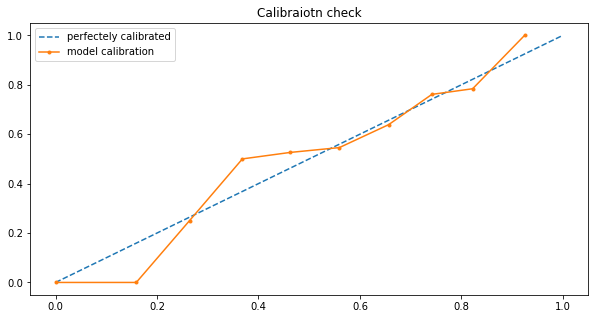

In [4]:
fig = plt.figure(figsize=(10,5))

# reliability diagram
fop, mpv = calibration_curve(T, propensity_score, n_bins=10)

# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')

# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.title("Calibraiotn check")
plt.legend(['perfectely calibrated','model calibration'])
plt.show()


## Trimming

In [5]:
# chekck for common support
upper_trim = np.min([np.max(propensity_score[T==1]),np.max(propensity_score[T==0])])
lower_trim = np.max([np.min(propensity_score[T==1]),np.min(propensity_score[T==0])])
indexes_to_take = (propensity_score<upper_trim) * (propensity_score>lower_trim)

# remove all sampples which are not in common support
X = X[indexes_to_take,:]
T = T[indexes_to_take]
Y = Y[indexes_to_take]

N = np.shape(X)[0]               # number of datapoints
Treated = X[T==1,:]              # only treated datapoints
N_treated = np.shape(Treated)[0] # number of treated

propensity_score = propensity_score[indexes_to_take]

## Check Overlapping

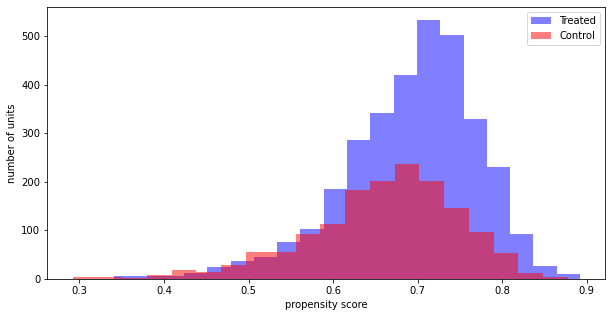

In [6]:
# plot propensity scores distribution of treated and untreated
fig = plt.figure(figsize=(10,5))
treat_plt = plt.hist(propensity_score[T==1], fc=(0, 0, 1, 0.5),bins=20,label='Treated')
cont_plt = plt.hist(propensity_score[T==0],fc=(1, 0, 0, 0.5),bins=20,label='Control')
plt.legend();
plt.xlabel('propensity score');
plt.ylabel('number of units');


## Estimate ATE using inverse propensity wegihtening

In [7]:
# calculate using hte inverse propensity firmula for ATT
ATT_inverse_propensity_1 = (np.sum(T * Y)/np.sum(T)) - (np.sum((1-T) * Y * (propensity_score/(1-propensity_score)))/np.sum((1-T) * (propensity_score/(1-propensity_score))))
print("ATT = "+str(ATT_inverse_propensity_1))

ATT = 4.336531292105946


## Estimate ATT using S learner

In [8]:
# add T as a feature
New_Features = np.concatenate((X, np.reshape(T,(N,1))), axis=1)

# fit a model
Outcome_estimator = linear_model.Ridge(alpha=1.0)
Outcome_estimator.fit(New_Features, Y)

# evaluate model with R^2
print("R^2 = " +str(Outcome_estimator.score(New_Features,Y)))

# use model to predict outcomes once when treated and once when not on Treated
#estimated_outcomes_1 = Outcome_estimator.predict(np.concatenate((Treated, np.ones((N_treated,1))), axis=1))
estimated_outcomes_1 = Y[T==1]
estimated_outcomes_0 = Outcome_estimator.predict(np.concatenate((Treated, np.zeros((N_treated,1))), axis=1))

# calcualte ATT
ATT_S_learner_1 = np.mean(estimated_outcomes_1 - estimated_outcomes_0)
print("ATT = "+str(ATT_S_learner_1))

R^2 = 0.5191376956996726
ATT = 4.636489489217852


## Estimate ATT using S learner 2d + 1

In [9]:
# add T and multiplications of T with the other features as new features
New_Features = np.concatenate((X, (X.T * T).T, np.reshape(T,(N,1))), axis=1)

# fit a model
Outcome_estimator = linear_model.Ridge(alpha=1.0)
Outcome_estimator.fit(New_Features, Y)

# evaluate model with R^2
print("R^2 = " +str(Outcome_estimator.score(New_Features,Y)))

# use model to predict outcomes once when treated and once when not on Treated
#estimated_outcomes_1 = Outcome_estimator.predict(np.concatenate((Treated, (Treated.T * np.ones(N_treated)).T, np.ones((N_treated,1))), axis=1))
estimated_outcomes_1 = Y[T==1]
estimated_outcomes_0 = Outcome_estimator.predict(np.concatenate((Treated, (Treated.T * np.zeros(N_treated)).T, np.zeros((N_treated,1))), axis=1))
           
# calcualte ATT    
ATT_S_learner_2d_1 = np.mean(estimated_outcomes_1 - estimated_outcomes_0)
print("ATT = "+str(ATT_S_learner_2d_1))


R^2 = 0.5871146103590379
ATT = 4.341596082543011


## Estimate ATT using T learner

In [10]:
# fit 2 models, one for treated and one for untreated
Outcome_estimator1 = linear_model.Ridge(alpha=1.0)
Outcome_estimator0 = linear_model.Ridge(alpha=1.0)

Outcome_estimator1.fit(X[T==1,:], Y[T==1])
Outcome_estimator0.fit(X[T==0,:], Y[T==0])

# evaluate models with R^2
print("R^2 Treated = " +str(Outcome_estimator1.score(X[T==1,:], Y[T==1])))
print("R^2 Control = " +str(Outcome_estimator0.score(X[T==0,:], Y[T==0])))

# use the model to predict outcomes on treated population
#estimated_outcomes_1 = Outcome_estimator1.predict(Treated)
estimated_outcomes_1 = Y[T==1]
estimated_outcomes_0 = Outcome_estimator0.predict(Treated)
  
# calcualte ATT        
ATT_T_learner_1 = np.mean(estimated_outcomes_1 - estimated_outcomes_0)
print("ATT = "+str(ATT_T_learner_1))

R^2 Treated = 0.4193753058459244
R^2 Control = 0.7165894948942979
ATT = 4.344372702869461


## Estiamte ATT using matching

In [11]:
k = 3 # num of neibours
p = 2 # whice p norm to use for distance

# find nearest neibours of treated population from the untreated population

# mahalanobis distance
#nbrs = NearestNeighbors(n_neighbors=k,metric='mahalanobis',metric_params={'V': np.cov(X.T)}).fit(X[T==0])

# regular p norm distance
nbrs = NearestNeighbors(n_neighbors=k,p=p).fit(X[T==0])

distances, indices = nbrs.kneighbors(X[T==1])

# calcualte ATT        
ATT_Matching_1 = np.mean(Y[T==1] - np.mean(Y[T==0][indices],axis=1))
print("ATT = "+str(ATT_Matching_1))

ATT = 4.139787492855213


## Estimate ATT for competition using Doubly robust estimator and random forest

In [12]:
# fit 2 models, one for treated and one for untreated
Outcome_estimator1 = RandomForestRegressor()
Outcome_estimator0 = RandomForestRegressor()

Outcome_estimator1.fit(X[T==1,:], Y[T==1])
Outcome_estimator0.fit(X[T==0,:], Y[T==0])

# evaluate models with R^2
print("R^2 Treated = " +str(Outcome_estimator1.score(X[T==1,:], Y[T==1])))
print("R^2 Control = " +str(Outcome_estimator0.score(X[T==0,:], Y[T==0])))

# use the model to predict outcomes on treated population
estimated_outcomes_1 = Outcome_estimator1.predict(Treated)
estimated_outcomes_0 = Outcome_estimator0.predict(Treated)

g1 = estimated_outcomes_1 + (1/propensity_score[T==1]) * (Y[T==1] - estimated_outcomes_1)
g0 = estimated_outcomes_0
  
# calcualte ATT        
ATT_Doubly_robust_1 = np.mean(g1 - g0)
print("ATT = "+str(ATT_Doubly_robust_1))   
    

R^2 Treated = 0.9925503652460561
R^2 Control = 0.9801872030787421
ATT = 4.232552503268786


## Estimate ATT for competition using Causal Forest

In [13]:
# fit causal forest to data
Outcome_estimator = CausalForest()
Outcome_estimator.fit(X=X,T=T,Y=Y)

# use the model to predict outcomes on treated population
effect = Outcome_estimator.const_marginal_effect(Treated)

# calcualte ATT        
ATT_Causal_Forest_1 = np.mean(effect)
print("ATT = "+str(ATT_Causal_Forest_1)) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 493 out of 500 | elapsed:   15.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:

ATT = 3.59157519614876


## Estimate ATT for competition using X - Learner with random forest

In [14]:
# fit 2 models, one for treated and one for untreated
Outcome_estimator1 = RandomForestRegressor()
Outcome_estimator0 = RandomForestRegressor()

Outcome_estimator1.fit(X[T==1,:], Y[T==1])
Outcome_estimator0.fit(X[T==0,:], Y[T==0])

# evaluate models with R^2
print("R^2 Treated = " +str(Outcome_estimator1.score(X[T==1,:], Y[T==1])))
print("R^2 Control = " +str(Outcome_estimator0.score(X[T==0,:], Y[T==0])))

# use the model to predict outcomes on treated population
estimated_outcomes_1 = Outcome_estimator1.predict(X)
estimated_outcomes_0 = Outcome_estimator0.predict(X)

tau1 = Y[T==1] - estimated_outcomes_0[T==1]
tau0 = estimated_outcomes_1[T==0] - Y[T==0]

tau1_estimator = RandomForestRegressor()
tau0_estimator = RandomForestRegressor()

tau1_estimator.fit(X[T==1,:], tau1)
tau0_estimator.fit(X[T==0,:], tau0)

# evaluate models with R^2
print("R^2 tau1 = " +str(tau1_estimator.score(X[T==1,:], tau1)))
print("R^2 tau0 = " +str(tau0_estimator.score(X[T==0,:], tau0)))

# use the model to predict outcomes on treated population
estimated_tau1 = tau1_estimator.predict(X)
estimated_tau0 = tau0_estimator.predict(X)

ITE = propensity_score * estimated_tau0 + (1-propensity_score) * estimated_tau1
 
# calcualte ATT        
ATT_X_Learner_1 = np.mean(ITE[T==1])
print("ATT = "+str(ATT_X_Learner_1)) 

R^2 Treated = 0.992527087473855
R^2 Control = 0.9805216861363063
R^2 tau1 = 0.9849260050996499
R^2 tau0 = 0.9818736666317961
ATT = 4.240958525758456


## Choose model for competition

In [15]:
ATT_Competition_1 = ATT_X_Learner_1

# Repeat procees for second dataset

## Load Dataset

In [16]:
# load datasets
data = pd.read_csv("../data2.csv") 

# extract treatment and outcome
T = data["T"].to_numpy()
Y = data["Y"].to_numpy()

# drop treatment and outcome
data = data.drop(columns=['T', 'Y'])

# cerate dummy features for catagorial features
data = pd.get_dummies(data, columns=['x_2', 'x_21','x_24'])

# extract features
X = data.iloc[:,1:].to_numpy()

# normlize dataset
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

# set general parametrs
N = np.shape(X)[0]               # number of datapoints
N_features = np.shape(X)[1]      # number of features
Treated = X[T==1,:]              # only treated datapoints
N_treated = np.shape(Treated)[0] # number of treated


## Estimating Propensity Scores

In [17]:
# train a logistic regression clasiifier for estimating the propensity score
propensity_estimator = linear_model.LogisticRegression(max_iter=1000)
#propensity_estimator = MLPClassifier(max_iter=1000)
#propensity_estimator = RandomForestClassifier()

# calibrate the clasiifier
#propensity_estimator = CalibratedClassifierCV(propensity_estimator)

# fit the model
propensity_estimator.fit(X, T)

# predict propensity_scores with the trained model
propensity_score = propensity_estimator.predict_proba(X)[:,1]

# save for results
propensity_score_2 = np.copy(propensity_score)

# evaluate estimator
print("AUROC : "+str(metrics.roc_auc_score(T, propensity_score)))


AUROC : 0.7065655660588683


## Check if the model is well calibrated

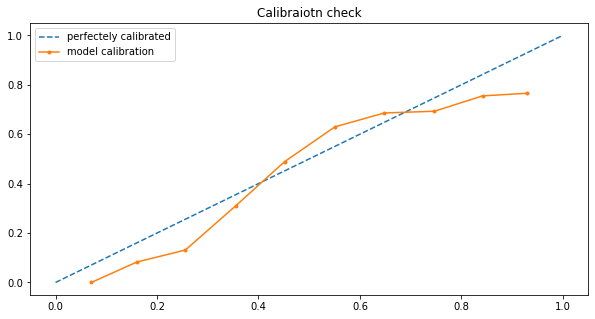

In [18]:
fig = plt.figure(figsize=(10,5))

# reliability diagram
fop, mpv = calibration_curve(T, propensity_score, n_bins=10)

# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')

# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.title("Calibraiotn check")
plt.legend(['perfectely calibrated','model calibration'])
plt.show()


## Trimming

In [19]:
# chekck for common support
upper_trim = np.min([np.max(propensity_score[T==1]),np.max(propensity_score[T==0])])
lower_trim = np.max([np.min(propensity_score[T==1]),np.min(propensity_score[T==0])])
indexes_to_take = (propensity_score<upper_trim) * (propensity_score>lower_trim)

# remove all sampples which are not in common support
X = X[indexes_to_take,:]
T = T[indexes_to_take]
Y = Y[indexes_to_take]

N = np.shape(X)[0]               # number of datapoints
Treated = X[T==1,:]              # only treated datapoints
N_treated = np.shape(Treated)[0] # number of treated

propensity_score = propensity_score[indexes_to_take]

## Check Overlapping

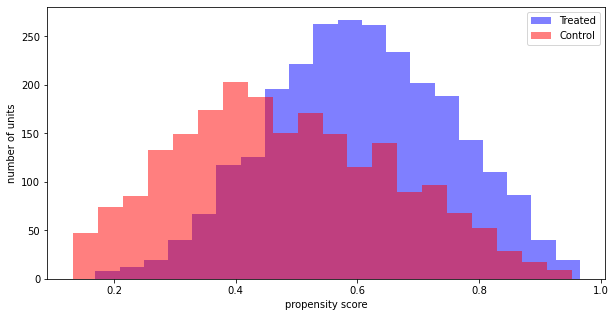

In [20]:
# plot propensity scores distribution of treated and untreated
fig = plt.figure(figsize=(10,5))
treat_plt = plt.hist(propensity_score[T==1], fc=(0, 0, 1, 0.5),bins=20,label='Treated')
cont_plt = plt.hist(propensity_score[T==0],fc=(1, 0, 0, 0.5),bins=20,label='Control')
plt.legend();
plt.xlabel('propensity score');
plt.ylabel('number of units');


## Estimate ATE using inverse propensity wegihtening

In [21]:
# calculate using hte inverse propensity firmula for ATT
ATT_inverse_propensity_2 = (np.sum(T * Y)/np.sum(T)) - (np.sum((1-T) * Y * (propensity_score/(1-propensity_score)))/np.sum((1-T) * (propensity_score/(1-propensity_score))))
print("ATT = "+str(ATT_inverse_propensity_2))

ATT = 3.3407620715769553


## Estimate ATT using S learner

In [22]:
# add T as a feature
New_Features = np.concatenate((X, np.reshape(T,(N,1))), axis=1)

# fit a model
Outcome_estimator = linear_model.Ridge(alpha=1.0)
Outcome_estimator.fit(New_Features, Y)

# evaluate model with R^2
print("R^2 = " +str(Outcome_estimator.score(New_Features,Y)))

# use model to predict outcomes once when treated and once when not on Treated
# estimated_outcomes_1 = Outcome_estimator.predict(np.concatenate((Treated, np.ones((N_treated,1))), axis=1))
estimated_outcomes_1 = Y[T==1]
estimated_outcomes_0 = Outcome_estimator.predict(np.concatenate((Treated, np.zeros((N_treated,1))), axis=1))

# calcualte ATT
ATT_S_learner_2 = np.mean(estimated_outcomes_1 - estimated_outcomes_0)
print("ATT = "+str(ATT_S_learner_2))

R^2 = 0.3570088884190653
ATT = 3.1127856116075434


## Estimate ATT using S learner 2d + 1

In [23]:
# add T and multiplications of T with the other features as new features
New_Features = np.concatenate((X, (X.T * T).T, np.reshape(T,(N,1))), axis=1)

# fit a model
Outcome_estimator = linear_model.Ridge(alpha=1.0)
Outcome_estimator.fit(New_Features, Y)

# evaluate model with R^2
print("R^2 = " +str(Outcome_estimator.score(New_Features,Y)))

# use model to predict outcomes once when treated and once when not on Treated
# estimated_outcomes_1 = Outcome_estimator.predict(np.concatenate((Treated, (Treated.T * np.ones(N_treated)).T, np.ones((N_treated,1))), axis=1))
estimated_outcomes_1 = Y[T==1]
estimated_outcomes_0 = Outcome_estimator.predict(np.concatenate((Treated, (Treated.T * np.zeros(N_treated)).T, np.zeros((N_treated,1))), axis=1))
           
# calcualte ATT    
ATT_S_learner_2d_2 = np.mean(estimated_outcomes_1 - estimated_outcomes_0)
print("ATT = "+str(ATT_S_learner_2d_2))


R^2 = 0.4032542174785363
ATT = 3.415975484295008


## Estimate ATT using T learner

In [24]:
# fit 2 models, one for treated and one for untreated
Outcome_estimator1 = linear_model.Ridge(alpha=1.0)
Outcome_estimator0 = linear_model.Ridge(alpha=1.0)

Outcome_estimator1.fit(X[T==1,:], Y[T==1])
Outcome_estimator0.fit(X[T==0,:], Y[T==0])

# evaluate models with R^2
print("R^2 Treated = " +str(Outcome_estimator1.score(X[T==1,:], Y[T==1])))
print("R^2 Control = " +str(Outcome_estimator0.score(X[T==0,:], Y[T==0])))

# use the model to predict outcomes on treated population
#estimated_outcomes_1 = Outcome_estimator1.predict(Treated)
estimated_outcomes_1 = Y[T==1]
estimated_outcomes_0 = Outcome_estimator0.predict(Treated)
  
# calcualte ATT        
ATT_T_learner_2 = np.mean(estimated_outcomes_1 - estimated_outcomes_0)
print("ATT = "+str(ATT_T_learner_2))

R^2 Treated = 0.26906558476616715
R^2 Control = 0.509560847573826
ATT = 3.418154294635806


## Estiamte ATT using matching

In [25]:
k = 3 # num of neibours
p = 2 # whice p norm to use for distance

# find nearest neibours of treated population from the untreated population

# mahalanobis distance
#nbrs = NearestNeighbors(n_neighbors=k,metric='mahalanobis',metric_params={'V': np.cov(X.T)}).fit(X[T==0])

# regular p norm distance
nbrs = NearestNeighbors(n_neighbors=k,p=p).fit(X[T==0])

distances, indices = nbrs.kneighbors(X[T==1])

# calcualte ATT        
ATT_Matching_2 = np.mean(Y[T==1] - np.mean(Y[T==0][indices],axis=1))
print("ATT = "+str(ATT_Matching_2))

ATT = 4.0597068866027115


## Estimate ATT for competition using Doubly robust estimator and random forest

In [26]:
# fit 2 models, one for treated and one for untreated
Outcome_estimator1 = RandomForestRegressor()
Outcome_estimator0 = RandomForestRegressor()

Outcome_estimator1.fit(X[T==1,:], Y[T==1])
Outcome_estimator0.fit(X[T==0,:], Y[T==0])

# evaluate models with R^2
print("R^2 Treated = " +str(Outcome_estimator1.score(X[T==1,:], Y[T==1])))
print("R^2 Control = " +str(Outcome_estimator0.score(X[T==0,:], Y[T==0])))

# use the model to predict outcomes on treated population
estimated_outcomes_1 = Outcome_estimator1.predict(Treated)
estimated_outcomes_0 = Outcome_estimator0.predict(Treated)

g1 = estimated_outcomes_1 + (1/propensity_score[T==1]) * (Y[T==1] - estimated_outcomes_1)
g0 = estimated_outcomes_0
  
# calcualte ATT        
ATT_Doubly_robust_2 = np.mean(g1 - g0)
print("ATT = "+str(ATT_Doubly_robust_2))   
    

R^2 Treated = 0.9931254305839754
R^2 Control = 0.9820820752371217
ATT = 2.5203208811839684


## Estimate ATT for competition using Causal Forest

In [27]:
# fit causal forest to data
Outcome_estimator = CausalForest()
Outcome_estimator.fit(X=X,T=T,Y=Y)

# use the model to predict outcomes on treated population
effect = Outcome_estimator.const_marginal_effect(Treated)

# calcualte ATT        
ATT_Causal_Forest_2 = np.mean(effect)
print("ATT = "+str(ATT_Causal_Forest_2))  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 996 tasks      | elapsed:  1.3min
[Parallel(

ATT = 3.824321775830159


## Estimate ATT for competition using X - Learner with random forest

In [28]:
# fit 2 models, one for treated and one for untreated
Outcome_estimator1 = RandomForestRegressor()
Outcome_estimator0 = RandomForestRegressor()

Outcome_estimator1.fit(X[T==1,:], Y[T==1])
Outcome_estimator0.fit(X[T==0,:], Y[T==0])

# evaluate models with R^2
print("R^2 Treated = " +str(Outcome_estimator1.score(X[T==1,:], Y[T==1])))
print("R^2 Control = " +str(Outcome_estimator0.score(X[T==0,:], Y[T==0])))

# use the model to predict outcomes on treated population
estimated_outcomes_1 = Outcome_estimator1.predict(X)
estimated_outcomes_0 = Outcome_estimator0.predict(X)

tau1 = Y[T==1] - estimated_outcomes_0[T==1]
tau0 = estimated_outcomes_1[T==0] - Y[T==0]

tau1_estimator = RandomForestRegressor()
tau0_estimator = RandomForestRegressor()

tau1_estimator.fit(X[T==1,:], tau1)
tau0_estimator.fit(X[T==0,:], tau0)

# evaluate models with R^2
print("R^2 tau1 = " +str(tau1_estimator.score(X[T==1,:], tau1)))
print("R^2 tau0 = " +str(tau0_estimator.score(X[T==0,:], tau0)))

# use the model to predict outcomes on treated population
estimated_tau1 = tau1_estimator.predict(X)
estimated_tau0 = tau0_estimator.predict(X)

ITE = propensity_score * estimated_tau0 + (1-propensity_score) * estimated_tau1
 
# calcualte ATT        
ATT_X_Learner_2 = np.mean(ITE[T==1])
print("ATT = "+str(ATT_X_Learner_2)) 

R^2 Treated = 0.9927672347444836
R^2 Control = 0.9824513055336013
R^2 tau1 = 0.971113586724636
R^2 tau0 = 0.9660024301182847
ATT = 2.364029173197324


## Choose model for competition

In [29]:
ATT_Competition_2 = ATT_Doubly_robust_2

## Save results

In [30]:
# save ATT estimates
res = {'Type': [1, 2, 3, 4, 5],
     'data1': [ATT_inverse_propensity_1, ATT_S_learner_2d_1,ATT_T_learner_1,ATT_Matching_1,ATT_Competition_1],
     'data2': [ATT_inverse_propensity_2, ATT_S_learner_2d_2,ATT_T_learner_2,ATT_Matching_2,ATT_Competition_2]}

df = pd.DataFrame(data=res)

df.to_csv("../ATT_results.csv",index=False)

# save propensity scores estimates
res = [propensity_score_1, propensity_score_2] 
  
df = pd.DataFrame(res, index = ['data1', 'data2']) 
  
df.to_csv("../models_propensity.csv",header=False)
